**Autora** : Rafaela Ramos Sarmento

**e-mail**: rafaelaramos.datasci@gmail.com

#  <a name="resumo"> RESUMO </a>
[Voltar ao índice](#indice)

A Base de dados trabalhada é a **'Santander Customer Transaction Prediction' disponível no link:** https://www.kaggle.com/c/santander-customer-transaction-prediction

Essa base de dados envolve um problema de classificação binária, isto é, a partir das features disponíveis, decidir se caso é X ou Y, ou de maneira binária, 0 ou 1.


#  <a name="indice">  Índice </a>

* [Resumo](#resumo)
* [Índice](#indice)
* [Problema a ser analisado](#secao_0)
* [Análise descritiva e exploratória](#secao_1)
* [Random Forest](#secao_2)
* [Regressão Logística](#secao_3)
* [GBDT - XGBOOST](#secao_4)
* [Redes Neurais](#secao_5)
* [Comparação Entre  os Modelos](#secao_6)
* [Conclusão do Desafio](#secao_7) 

#  <a name="secao_0"> Problema a ser analisado </a>
[Voltar ao índice](#indice)

Como a base de dados do **'Santander Customer Transaction Prediction'** tem o seguinte texto guia: 

   * "In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem." *


Como temos um problema de classificação binária, e o próprio desafio sugere que a análise conste como uma previsão de que os clientes do banco realizem uma determinada operação no futuro, dadas as variáveis disponíveis no banco de dados do Santander, podemos formular um problema de negócio em que o banco estará oferecendo para o cliente um investimento de renda fixa do programa “Renda Mais”. Neste caso, os modelos de machine learning tem o objetivo de prever se um dado cliente irá participar do programa ou não.

Assim, as variáveis disponíveis poderiam ser interpretados como informações relacionadas a empréstimos realizados e pagos, pagamentos, idade, renda, situação civil e outras trasações e investimentos no banco.

Portanto, queremos criar um modelo de previsão que forneça o indicativo sobre quais clientes possuem maior probabilidade de fazer parte do programa "Renda Mais", de forma que os clientes classificados positivamente (1) receberão e-mails com propostas e propagandas referentes ao programa de investimento.

Para este caso, observa-se que falsos positivos (FP) não são um problema grave, uma vez que um cliente que seja classificado positivamente mas que não tenha interesse no programa poderá apenas ignorar ou recusar a oferta. Entretanto, o caso de falso negativo (FN) é considerado um problema grave, uma vez que o cliente classificado negativamente mas que tenha interesse em investir não recebera a oferta e, assim, o banco perde um cliente em potencial e não haverá lucros. A métrica de classificação de maior importância é o recall, de forma que maximizando o recall estaremos diminuindo o número de falsos negativos.
O recall é dado pela equação:


$$ recall = \frac{VP}{VP + FN}$$



O problema consta com a variável **ID_code** que é a identificação do cliente, a **target** que é o problema que estamos querendo resolver, isto é, é a variável do tipo classe (binária, 0 ou 1), e teremos um total de **200** features, identificadas como: var_0, var_1, ..., var_199.

Um detalhe é que a base de dados de teste não possui a coluna target, então não seria possível verificar as métricas do nosso modelo utilizando esses dados, portanto, o que será feito é dividir a base de treino em duas: uma efetivamente de treino e outra de validação, de forma a ter uma proporção 70% e 30%, respectivamente.
Além disso, a base de dados já esta bastante limpa, não sendo necessário fazer um trabalho arduo de pré-processamento dos dados.


#  <a name="secao_1"> Análise descritiva e exploratória </a>
[Voltar ao índice](#indice)

Vamos calcular algumas propriedades estatisticas dessa base de dados.

   - Não há valores nulos;
   - Dados em mesmo range de escala;
   - Classes desbalanceadas -> proporção 9 (0) para 1 (1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import statistics as sts
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split

In [2]:
#criando funcao para ter informacoes sobre os dados
def show_info(data) :
    print('DATASET SHAPE: ', data.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(data.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(data.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(data.isnull().sum())
  

In [69]:
def plota_roc_curve(modelo, X_validacao, Y_validacao, nome_modelo, color_roc = "pink") :
    sk.metrics.plot_roc_curve(modelo, X_validacao, Y_validacao, name="%s" % nome_modelo, color='%s'%color_roc)
    plt.title('Curva ROC', fontsize=15)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('1- Especificidade', fontsize=12)
    plt.ylabel('Sensibilidade', fontsize=12)
    plt.grid(color='w', linestyle='dotted', linewidth=1)
    plt.legend()
    #plt.show()

In [4]:
def plot_curva_learning(modelo, nome_modelo) :
    results = modelo.evals_result()
    # plot learning curves
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.title('LogLoss vs n_estimator - %s' %nome_modelo)
    plt.ylabel('LogLoss')
    plt.xlabel('n_estimator')
    plt.grid(color='w', linestyle='dotted', linewidth=1)
    plt.legend()
    plt.show()

In [6]:
df = pd.read_csv("../santander-customer-transaction-prediction/train.csv")
df_train, df_validacao = train_test_split(df, train_size=0.7, shuffle=True)

#df_test = pd.read_csv("santander-customer-transaction-prediction/test.csv")

In [7]:
#criando os arrays para X {variaveis previsoras} e Y {variavel tipo classe} para treino e teste
Y_train = df_train.iloc[:, 1].values
X_train = df_train.iloc[:, 2:].values
Y_validacao = df_validacao.iloc[:, 1].values 
X_validacao = df_validacao.iloc[:, 2:].values

In [8]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
88875,train_88875,0,10.2140,-1.6712,12.4534,6.2898,10.9933,-9.3711,4.4673,17.4296,...,-3.4038,9.8534,-0.2260,-1.4909,21.2089,-1.0007,-3.8732,8.0180,18.4076,-3.5262
196713,train_196713,0,10.8859,-2.9397,9.4486,9.0127,11.2737,13.2660,5.1459,14.2890,...,12.2761,6.5860,2.7400,6.0245,19.6345,-1.0330,0.2392,8.5782,17.5441,-5.8254
7278,train_7278,0,13.4643,2.3387,14.8030,4.2911,13.8553,0.5665,5.3234,22.9301,...,-5.8925,6.3949,1.3124,-5.2226,17.9139,2.3752,-3.9287,7.6504,18.2337,-21.2716
56958,train_56958,0,5.1080,-0.9866,11.3163,7.8951,8.1722,5.2082,6.9711,19.3393,...,3.9590,4.5531,-0.5873,2.9222,17.9934,1.7334,9.7244,9.2116,19.6848,-11.4541
137165,train_137165,0,7.2523,-4.7387,9.9817,9.6120,10.8336,-6.1715,6.4829,20.3842,...,-0.9966,1.9151,1.3997,6.2295,19.9307,-2.1361,8.1483,8.5908,15.2996,15.6393


In [9]:
show_info(df_train)

DATASET SHAPE:  (140000, 202) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140000 entries, 88875 to 192693
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 216.8+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

ID_code    140000
target          2
var_0       79719
var_1       89492
var_2       74218
            ...  
var_195     52418
var_196     99849
var_197     37894
var_198     79458
var_199    113656
Length: 202, dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64


In [10]:
show_info(df_validacao)

DATASET SHAPE:  (60000, 202) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 46927 to 103004
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 92.9+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

ID_code    60000
target         2
var_0      45877
var_1      48608
var_2      44197
           ...  
var_195    36324
var_196    51396
var_197    29091
var_198    45872
var_199    54632
Length: 202, dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64


#### Primeiras observações 

Legenda para entendimento do problema: 
   *  ID_code :  identificação do cliente
   *  target: variável que queremos prever
   *  var_i ; i = 0, 1, ..., 199
   
observa-se que em ambos conjuntos de dados, treino e validacao, não há valores nulos. Também não será necessário fazer processo de cleaning e escalonamento, visto que as variáveis estão sem significado e as ordens de grandeza estão próximas. 

Temos um caso de classes desbalanceadas, sendo as contagens:
  - Treino:
      * classe 0 : 125972 contagens  
      * classe 1 : 14028 contagens
  - Validação:
      * classe 0 : 53930 contagens  
      * classe 1 : 6070 contagens

In [11]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,...,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,0.100343,10.674161,-1.635176,10.720719,6.798151,11.080091,-5.072312,5.410635,16.544791,0.288824,...,3.230404,7.440879,1.927573,3.334550,17.990972,-0.138425,2.299417,8.908526,15.868868,-3.347517
std,0.300458,3.040840,4.060137,2.640049,2.046215,1.624402,7.872537,0.865695,3.416785,3.330959,...,4.565341,3.023174,1.478932,3.995588,3.130211,1.427583,5.451353,0.921110,3.010185,10.435513
min,0.000000,0.408400,-14.696200,2.117100,-0.040200,5.277800,-32.562600,2.495700,5.349700,-9.991100,...,-13.180800,-2.123000,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,6.047600,6.644800,-38.852800
25%,0.000000,8.450700,-4.759900,8.731775,5.253075,9.886100,-11.217600,4.770700,13.943550,-2.314025,...,-0.066825,5.158275,0.889175,0.594575,15.635000,-1.166900,-1.948025,8.253800,13.830900,-11.230725
50%,0.000000,10.522800,-1.619400,10.585750,6.825800,11.108500,-4.837050,5.387900,16.452400,0.403350,...,3.204700,7.356800,1.901300,3.402100,17.957300,-0.168000,2.405450,8.889800,15.933800,-2.860900
75%,0.000000,12.757100,1.359400,12.522700,8.324325,12.266100,0.918025,6.004600,19.098800,2.942925,...,6.403025,9.510700,2.949700,6.214400,20.393350,0.833200,6.555025,9.592500,18.062700,4.820250
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.433000,27.638900,10.151300,...,18.431800,16.716500,7.811100,18.281800,27.597300,4.166800,17.684100,12.000400,26.079100,28.500700


In [12]:
df_validacao.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.100833,10.693338,-1.609995,10.702296,6.792745,11.074233,-5.048998,5.405014,16.548320,0.273284,...,3.243856,7.432643,1.928457,3.325295,18.000345,-0.150637,2.312478,8.907297,15.875043,-3.277584
std,0.301110,3.038192,4.026374,2.642841,2.036558,1.620230,7.841635,0.868727,3.421112,3.336540,...,4.547276,3.023517,1.477246,3.983743,3.146700,1.433514,5.461435,0.922835,3.012739,10.443775
min,0.000000,0.452800,-15.043400,2.789200,0.170700,5.074800,-28.246100,2.347300,6.889000,-10.505500,...,-14.093300,-2.691700,-3.410700,-10.311600,9.144600,-5.048100,-13.589100,5.960600,6.299300,-38.852800
25%,0.000000,8.466025,-4.691550,8.703450,5.256775,9.873900,-11.153100,4.760500,13.945350,-2.326125,...,-0.040725,5.156225,0.891575,0.559500,15.619000,-1.179600,-1.943875,8.249175,13.825925,-11.159625
50%,0.000000,10.531600,-1.587500,10.567600,6.823050,11.107900,-4.824250,5.379300,16.466450,0.368250,...,3.201050,7.325750,1.901400,3.381000,17.959250,-0.182950,2.416850,8.883600,15.934900,-2.730550
75%,0.000000,12.761925,1.357650,12.502025,8.323625,12.251400,0.938425,5.999300,19.111175,2.927200,...,6.414425,9.514900,2.948900,6.181325,20.402625,0.821325,6.562450,9.595500,18.070800,4.869700
max,1.000000,20.074000,9.188300,18.652100,13.098300,15.778800,17.128100,8.447700,27.691800,9.627200,...,18.440900,16.684600,8.402400,17.527300,27.928800,4.272900,18.321500,11.887600,25.857100,27.534000


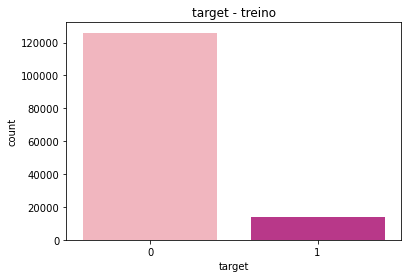

In [13]:
#verificando a quantidade de cada classe dentro do conjunto de dados de treino
sns.countplot(x=df_train['target'], palette = 'RdPu').set_title('target - treino')
plt.show()

In [14]:
np.unique(Y_train, return_counts = True)

(array([0, 1]), array([125952,  14048]))

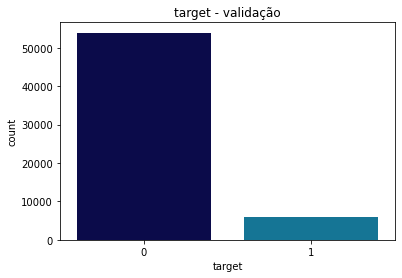

In [15]:
#verificando a quantidade de cada classe dentro do conjunto de dados de validacao
sns.countplot(x=df_validacao['target'], palette = 'ocean').set_title('target - validação')
plt.show()

In [16]:
np.unique(Y_validacao, return_counts = True)

(array([0, 1]), array([53950,  6050]))

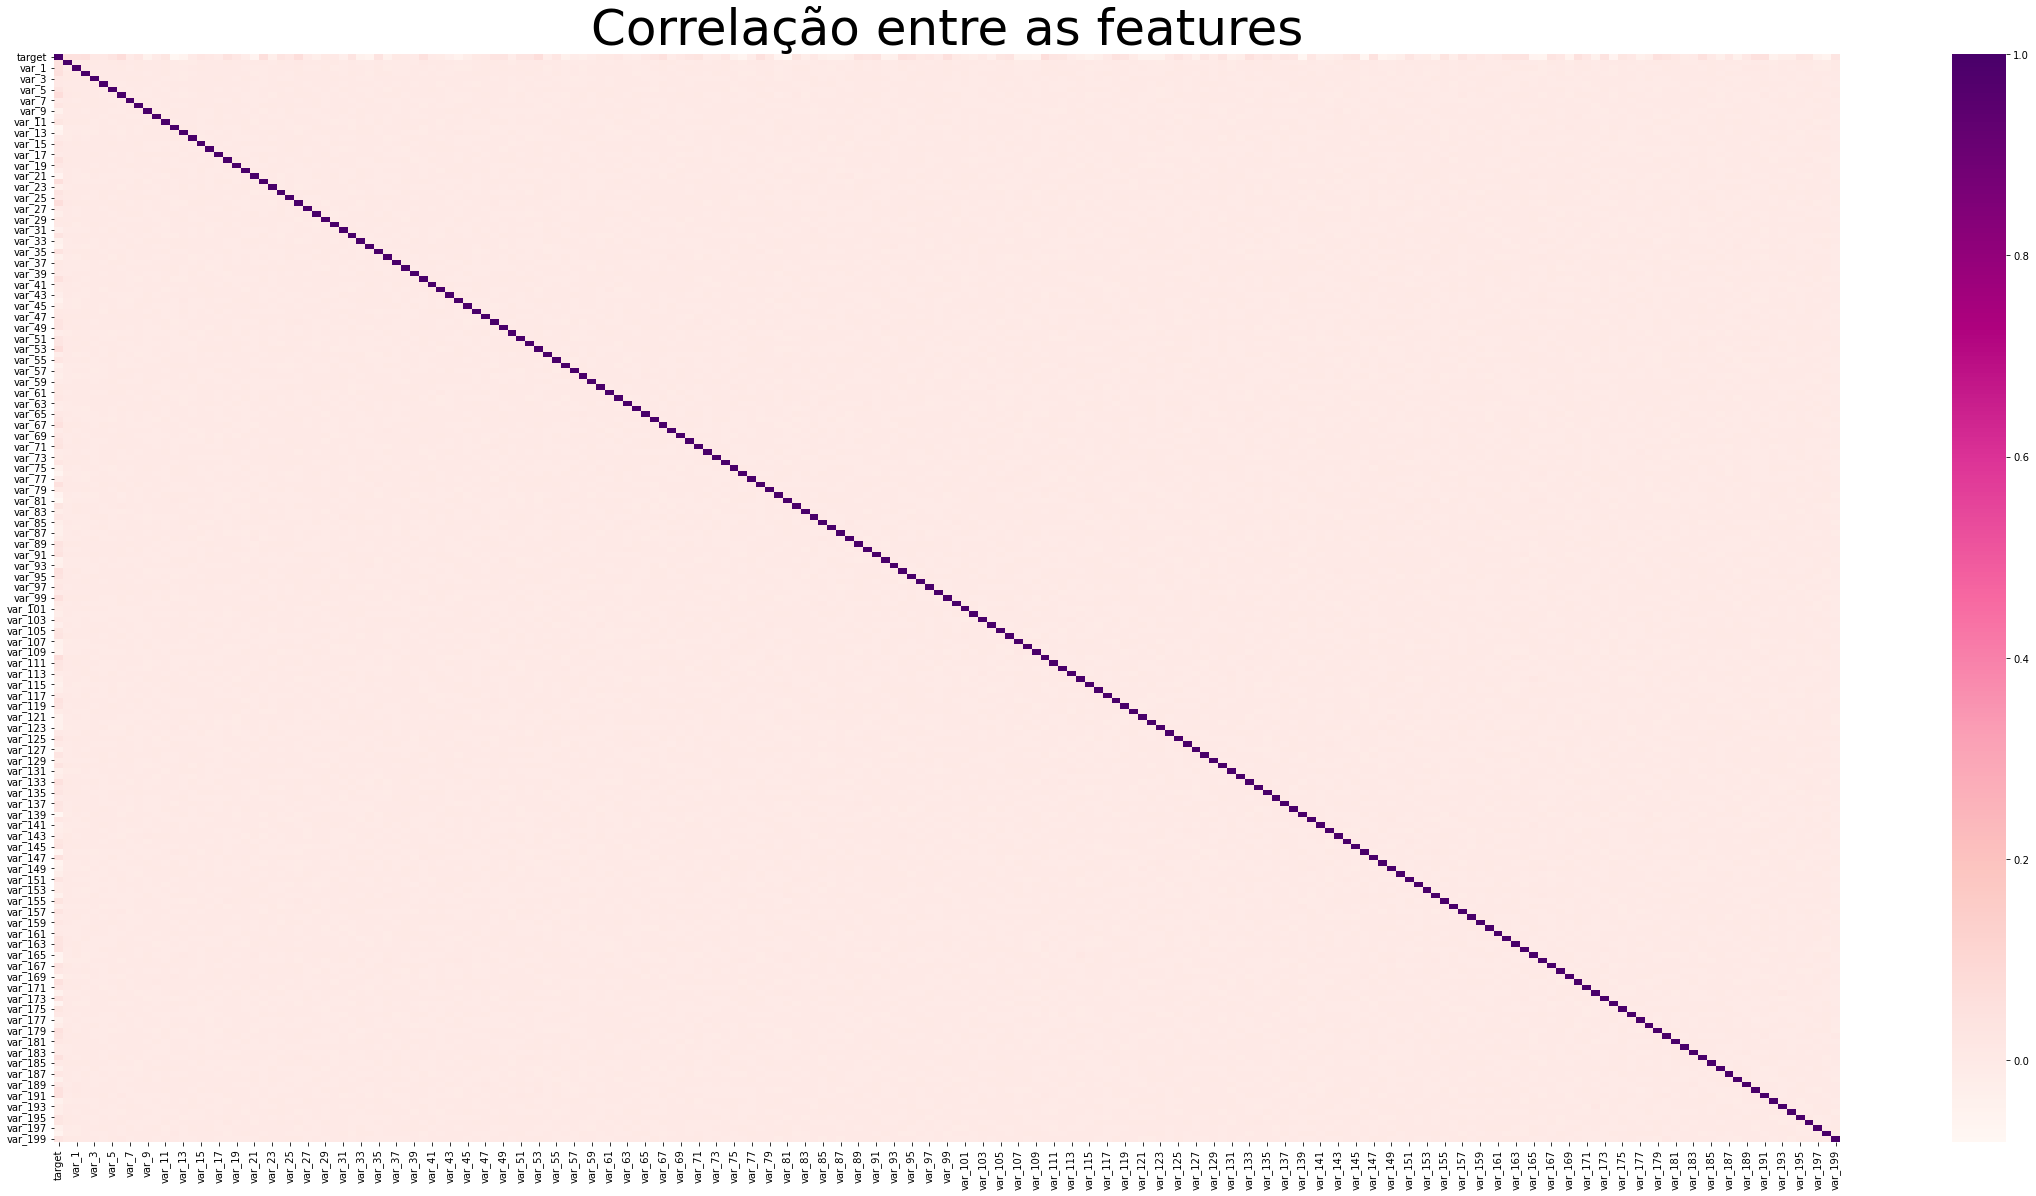

In [17]:
#calculo da matriz de correlação entre as variáveis do problema
plt.figure(figsize=(40,20)) 
plt.title('Correlação entre as features', size = 50) 
sns.heatmap(df_train.corr(), cmap='RdPu')
plt.show()

A seguir, o calculo matriz de correlacao, verifica quais entradas é maior que 0.5 e faz a contagem. A diagonal sempre vai valer 1, se tiver 201 contagens nao nulas, entao as variaveis nao sao correlacionadas.

In [18]:
correlacao = df_train.corr()
qtd_correlacao = np.where(abs(correlacao)>0.5, 1, 0)
np.count_nonzero(qtd_correlacao), qtd_correlacao

(201,
 array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]]))

#  <a name="secao_2"> Random Forest </a>
[Voltar ao índice](#indice)

Vamos iniciar o processo de previsão utilizando um algoritmo mais simples, o Random Forest.

Para este caso, foi testado alguns modelos manualmente e após isso foi utilizado o GridSearchCV() para encontrar o melhor modelo dentro de algumas possibilidades de hiper parâmetros. 

Com o melhor modelo, foi calculado as principais métricas para um caso de classificação, sendo elas a matriz de confusão, precision, recall e a curva ROC. Também foi plotado as 10 features mais importantes para o treino do modelo, essa informação poderia ser utilizada para eliminar features pouco importantes e deixar o treino com um custo computacional menor. Esse ultimo processo não foi feito nessa análise.


Parâmetros utilizados e variados:
   - n_estimator
   - max_depth
   - criterion = 'entropy' (fixo)
   
métrica maximizada: **recall** 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - n_estimator: 200
   - max_depth: 12

   
Com o recall sendo igual a:
   - Recall Score : 0.7262
   

In [ ]:
!pip install imblearn

In [ ]:
pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, roc_auc_score
from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import BorderlineSMOTE 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_curve

In [20]:
X_train.shape, Y_train.shape

((140000, 200), (140000,))

In [21]:
X_validacao.shape, Y_validacao.shape

((60000, 200), (60000,))

In [22]:
#balanceando os dados, de forma a usar a técnica de oversampling
smote_random_forest = BorderlineSMOTE(sampling_strategy='minority')
X_over_train, Y_over_train = smote_random_forest.fit_resample(X_train, Y_train)
X_over_validacao, Y_over_validacao = smote_random_forest.fit_resample(X_validacao, Y_validacao)

In [23]:
np.unique(Y_over_train, return_counts=True)

(array([0, 1]), array([125952, 125952]))

In [24]:
np.unique(Y_over_validacao, return_counts=True)

(array([0, 1]), array([53950, 53950]))

In [25]:
#inciando o treinamento com a Random Forest, usando a metrica para hierarquia das features
#a minimizacao da entropia (maximizacao do ganho de informacao)
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=12, verbose=1,random_state = 0)
random_forest.fit(X_over_train, Y_over_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 21.3min finished


RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=0, verbose=1)

In [26]:
previsoes_random_forest = random_forest.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_random_forest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.6s finished


0.7262835959221502

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


0.7978591288229843

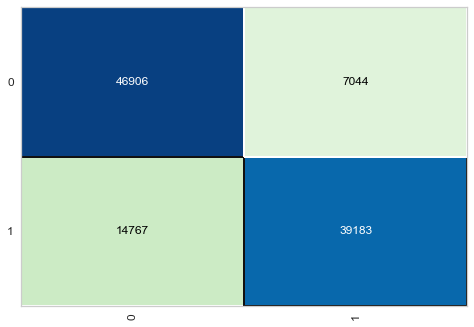

In [27]:
#calculo de algumas métricas de classificação: matriz de confusao
matriz_confusao_random_forest = ConfusionMatrix(random_forest, cmap='GnBu')
matriz_confusao_random_forest.fit(X_over_train, Y_over_train)
matriz_confusao_random_forest.score(X_over_validacao, Y_over_validacao)

In [28]:
#printa as métricas de classificação
print(classification_report(Y_over_validacao, previsoes_random_forest))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81     53950
           1       0.85      0.73      0.78     53950

    accuracy                           0.80    107900
   macro avg       0.80      0.80      0.80    107900
weighted avg       0.80      0.80      0.80    107900



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.4s finished


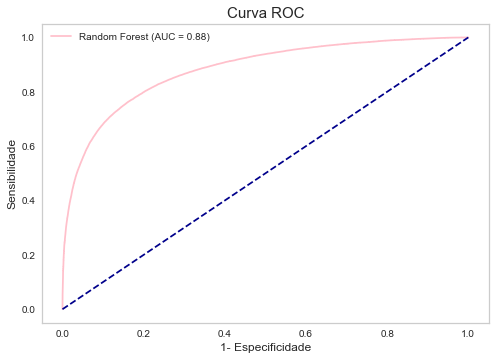

In [40]:
roc_random_forest = plota_roc_curve(random_forest, X_over_validacao, Y_over_validacao, 'Random Forest', color_roc = "pink")
plt.show()


<AxesSubplot:>

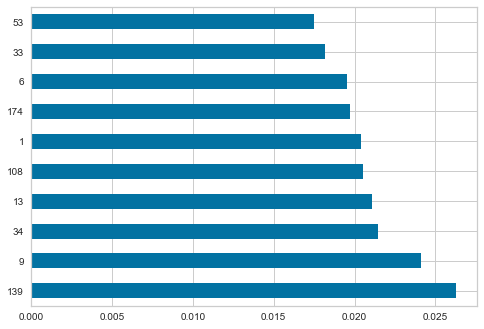

In [ ]:
#plotando o ranking de importancia das features utilizadas para treinar o meu modelo
feat_importances = pd.Series(random_forest.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#tunando os hyperparametros com o gridsearch:
parametros = {'criterion': ['entropy'], 
              'n_estimators': [50, 100, 200],
              'max_depth': [6, 9, 12],
               'random_state': [0]}  

grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros, scoring='recall', cv=2)
grid_rf.fit(X_over_train, Y_over_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [6, 9, 12],
                         'n_estimators': [50, 100, 200], 'random_state': [0]},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_rf.best_estimator_))
print('Best Score: ' + str(grid_rf.best_score_))

Melhor modelo: RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=0)
Best Score: 0.9100629240086487


#  <a name="secao_3"> Regressão Logística </a>
[Voltar ao índice](#indice)

Tentando um modelo mais simples para verificar como os dados se comportam. Para isso, será utilizado a regressão logística.

Parâmetros utilizados e variados:
   - max_iter
   - solver
   
métrica maximizada: recall 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - max_iter: 1500
   - solver: 'lbfgs'
   
Com o recall sendo igual a:
   - recall: 0.8060

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
logistic_regression = LogisticRegression(max_iter=1500, random_state = 0)
logistic_regression.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1500, random_state=0)

In [43]:
#logistic_regression.coef_

In [44]:
previsoes_logistic = logistic_regression.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_logistic)

0.8088971269694162

0.8060704355885079

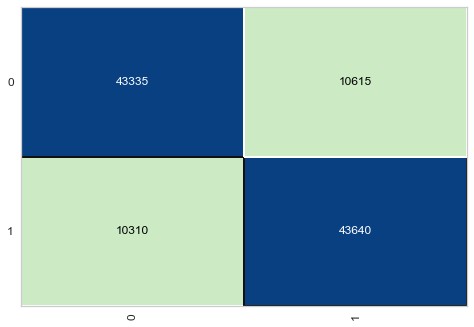

In [45]:
matriz_confusao_logistic = ConfusionMatrix(logistic_regression, cmap='GnBu')
matriz_confusao_logistic.fit(X_over_train, Y_over_train)
matriz_confusao_logistic.score(X_over_validacao, Y_over_validacao)

In [46]:
print(classification_report(Y_over_validacao, previsoes_logistic))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81     53950
           1       0.80      0.81      0.81     53950

    accuracy                           0.81    107900
   macro avg       0.81      0.81      0.81    107900
weighted avg       0.81      0.81      0.81    107900



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


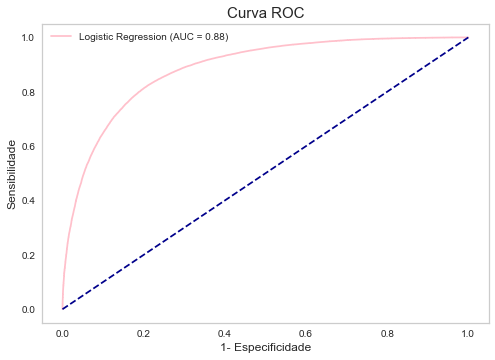

In [53]:
roc_logistic = plota_roc_curve(logistic_regression, X_over_validacao, Y_over_validacao, 'Logistic Regression', color_roc = "pink")
plt.show()

In [ ]:
#tunando os hiperparametros da logistic regression com o GridSearchCV()
parametros_logistic = {'max_iter': [100, 300, 500, 1000, 1500],
                   'solver': ['lbfgs', 'saga'],
               }  

grid_logistic= GridSearchCV(estimator=LogisticRegression(), param_grid=parametros_logistic, cv=2, scoring='recall', verbose=0)
grid_logistic.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 300, 500, 1000, 1500],
                         'solver': ['lbfgs', 'saga']},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_logistic.best_estimator_))
print('Best Score: ' + str(grid_logistic.best_score_))

Melhor modelo: LogisticRegression(max_iter=1500)
Best Score: 0.822676229584365


#  <a name="secao_4"> GBDT - XGBOOST </a>
[Voltar ao índice](#indice)

Utilizando a GBDT, um algoritmo mais avançado, em que teremos um ensemble de decisions trees trabalhando de forma sequencial. A GBDT aqui é implementada pela biblioteca XGBoost.

Parâmetros utilizados e variados:
   - n_estimator
   - max_depth
   - learning_rate

métrica maximizada: recall 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - n_estimator: 200
   - max_depth: 9
   - learning_rate: 0.3 
   
Com o recall sendo igual a:
   - recall: 0.7417

Entretanto, este modelo overfitou, assim, os parâmetros foram atualizados e adicionou-se um parâmetro de regularização (L2 - reg_gamma). De forma, que obteve-se o resultado:
   - n_estimator: 500
   - max_depth: 4
   - learning_rate: 0.1 
   
Com o recall sendo igual a:
   - recall: 0.8246

In [48]:
import xgboost as xgb
import xgboost as get_score
from sklearn.metrics import log_loss

In [49]:
#treinando modelo com os dados já balanceados pela etapa do random forest
GBDT = xgb.XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.1,random_state=0, reg_lambda=0.1)
GBDT.fit(X_over_train, Y_over_train, eval_metric='logloss', eval_set=[(X_over_train, Y_over_train), (X_over_validacao, Y_over_validacao)])

[0]	validation_0-logloss:0.686779	validation_1-logloss:0.687546
[1]	validation_0-logloss:0.680754	validation_1-logloss:0.682463
[2]	validation_0-logloss:0.675043	validation_1-logloss:0.676994
[3]	validation_0-logloss:0.669569	validation_1-logloss:0.671953
[4]	validation_0-logloss:0.664246	validation_1-logloss:0.667499
[5]	validation_0-logloss:0.659224	validation_1-logloss:0.663149
[6]	validation_0-logloss:0.654268	validation_1-logloss:0.658688
[7]	validation_0-logloss:0.64948	validation_1-logloss:0.65458
[8]	validation_0-logloss:0.644629	validation_1-logloss:0.650721
[9]	validation_0-logloss:0.640084	validation_1-logloss:0.646584
[10]	validation_0-logloss:0.635714	validation_1-logloss:0.642793
[11]	validation_0-logloss:0.631447	validation_1-logloss:0.638793
[12]	validation_0-logloss:0.627205	validation_1-logloss:0.634642
[13]	validation_0-logloss:0.62301	validation_1-logloss:0.630997
[14]	validation_0-logloss:0.618987	validation_1-logloss:0.627537
[15]	validation_0-logloss:0.614973	val

[127]	validation_0-logloss:0.394118	validation_1-logloss:0.434281
[128]	validation_0-logloss:0.393085	validation_1-logloss:0.433424
[129]	validation_0-logloss:0.391997	validation_1-logloss:0.432655
[130]	validation_0-logloss:0.391016	validation_1-logloss:0.431703
[131]	validation_0-logloss:0.390042	validation_1-logloss:0.4308
[132]	validation_0-logloss:0.388956	validation_1-logloss:0.43004
[133]	validation_0-logloss:0.38796	validation_1-logloss:0.429252
[134]	validation_0-logloss:0.387011	validation_1-logloss:0.428455
[135]	validation_0-logloss:0.385998	validation_1-logloss:0.427751
[136]	validation_0-logloss:0.385069	validation_1-logloss:0.427027
[137]	validation_0-logloss:0.384095	validation_1-logloss:0.426307
[138]	validation_0-logloss:0.383169	validation_1-logloss:0.425626
[139]	validation_0-logloss:0.382241	validation_1-logloss:0.424819
[140]	validation_0-logloss:0.381278	validation_1-logloss:0.424031
[141]	validation_0-logloss:0.380281	validation_1-logloss:0.423096
[142]	validati

[252]	validation_0-logloss:0.305784	validation_1-logloss:0.366324
[253]	validation_0-logloss:0.305305	validation_1-logloss:0.365946
[254]	validation_0-logloss:0.304807	validation_1-logloss:0.36563
[255]	validation_0-logloss:0.304339	validation_1-logloss:0.365331
[256]	validation_0-logloss:0.303825	validation_1-logloss:0.364932
[257]	validation_0-logloss:0.303343	validation_1-logloss:0.364597
[258]	validation_0-logloss:0.302879	validation_1-logloss:0.364259
[259]	validation_0-logloss:0.302393	validation_1-logloss:0.363976
[260]	validation_0-logloss:0.301916	validation_1-logloss:0.363639
[261]	validation_0-logloss:0.30145	validation_1-logloss:0.363275
[262]	validation_0-logloss:0.300964	validation_1-logloss:0.362893
[263]	validation_0-logloss:0.300559	validation_1-logloss:0.36259
[264]	validation_0-logloss:0.300085	validation_1-logloss:0.36229
[265]	validation_0-logloss:0.299681	validation_1-logloss:0.362059
[266]	validation_0-logloss:0.299199	validation_1-logloss:0.361823
[267]	validati

[377]	validation_0-logloss:0.259148	validation_1-logloss:0.335459
[378]	validation_0-logloss:0.258888	validation_1-logloss:0.335265
[379]	validation_0-logloss:0.258619	validation_1-logloss:0.335086
[380]	validation_0-logloss:0.258306	validation_1-logloss:0.33487
[381]	validation_0-logloss:0.258031	validation_1-logloss:0.334739
[382]	validation_0-logloss:0.257746	validation_1-logloss:0.334605
[383]	validation_0-logloss:0.257426	validation_1-logloss:0.334398
[384]	validation_0-logloss:0.257167	validation_1-logloss:0.334262
[385]	validation_0-logloss:0.256862	validation_1-logloss:0.33408
[386]	validation_0-logloss:0.256599	validation_1-logloss:0.333967
[387]	validation_0-logloss:0.256318	validation_1-logloss:0.333859
[388]	validation_0-logloss:0.256098	validation_1-logloss:0.333662
[389]	validation_0-logloss:0.255833	validation_1-logloss:0.333445
[390]	validation_0-logloss:0.255594	validation_1-logloss:0.333274
[391]	validation_0-logloss:0.255312	validation_1-logloss:0.333063
[392]	valida

XGBClassifier(max_depth=4, n_estimators=500, reg_lambda=0.1)

In [50]:
previsoes_gbdt = GBDT.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_gbdt)

0.8246895273401298

0.8738924930491195

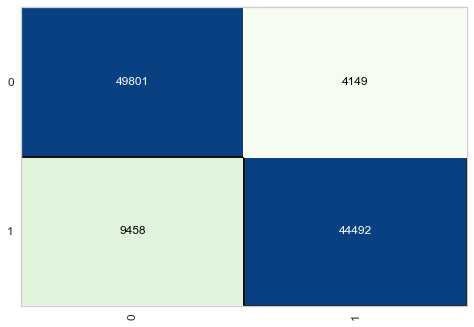

In [51]:
#calculo de algumas métricas de classificação: matriz de confusao
matriz_confusao_gbdt = ConfusionMatrix(GBDT, cmap='GnBu')
matriz_confusao_gbdt.fit(X_over_train, Y_over_train)
matriz_confusao_gbdt.score(X_over_validacao, Y_over_validacao)

In [52]:
#printa as métricas de classificação
print(classification_report(Y_over_validacao, previsoes_gbdt))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     53950
           1       0.91      0.82      0.87     53950

    accuracy                           0.87    107900
   macro avg       0.88      0.87      0.87    107900
weighted avg       0.88      0.87      0.87    107900



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


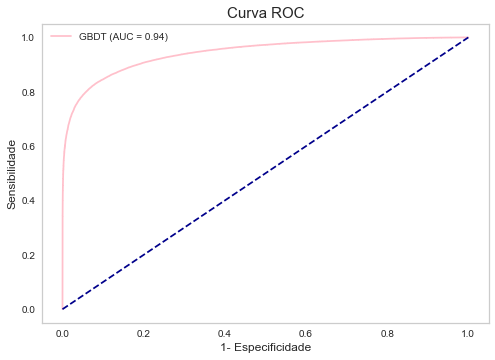

In [56]:
roc_gbdt = plota_roc_curve(GBDT, X_over_validacao, Y_over_validacao, "GBDT")

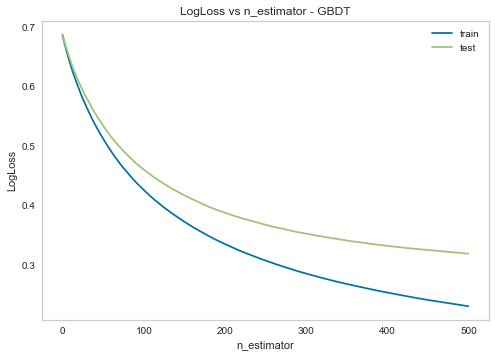

In [57]:
logloss_gbdt = plot_curva_learning(GBDT, 'GBDT')

<AxesSubplot:>

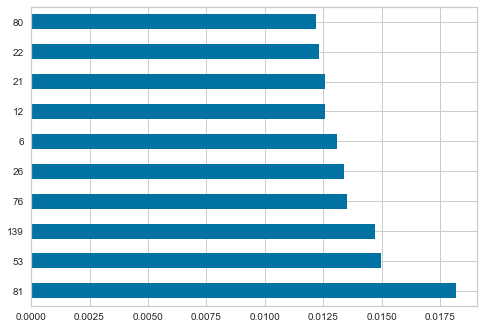

In [58]:
feat_importances = pd.Series(GBDT.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#tunando os hiperparametros da GBDT com o GridSearchCV()
parametros_gbdt = {'n_estimators': [100, 150, 200],
              'max_depth': [3, 6, 9],
                   'learning_rate': [0.1],
               }  

grid_gbdt = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=parametros_gbdt, cv=2, scoring='recall', verbose=0)
grid_gbdt.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:59:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:02:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:05:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:09:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:30:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:39:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:27:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:16:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_grid={'max_depth': [3, 5, 9],
                         'n_estimators': [100, 150, 200]},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_gbdt.best_estimator_))
print('Best Score: ' + str(grid_gbdt.best_score_))

Melhor modelo: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Score: 0.9375585850643632


#  <a name="secao_5"> Redes Neurais </a>
[Voltar ao índice](#indice)

Para a aplicação de redes neurais para resolver o problema, será utilizado uma rede neural simples, implementada pelo sklearn, a MLPClassifier()   (MultiLayer Perceptron).

Parâmetros utilizados e variados:
   - max_iter (epocas)
   - activation = 'logistic'
   - hidden_layer_sizes 
   
métrica maximizada: recall 

O melhor modelo encontrado:
   - max_iter (epocas) = 300 (efetivos=78)
   - hidden_layer_sizes = (100, 50, 25, 13,7) 
   
Com o recall sendo igual a:
   - recall: 0.8024
   

In [59]:
from sklearn.neural_network import MLPClassifier

In [60]:
# 200 (neuronios entrada) -> 100 (1 camada oculta com 100 neuronios) -> 1 (neuronio saida)
rede_neural = MLPClassifier(max_iter=300, verbose=True, hidden_layer_sizes = (100, 50, 25, 13,7), activation='logistic', random_state=0)
rede_neural.fit(X_over_train, Y_over_train)

Iteration 1, loss = 0.53956545
Iteration 2, loss = 0.44623350
Iteration 3, loss = 0.42696295
Iteration 4, loss = 0.41745976
Iteration 5, loss = 0.41333270
Iteration 6, loss = 0.40774099
Iteration 7, loss = 0.40501559
Iteration 8, loss = 0.40285528
Iteration 9, loss = 0.39936332
Iteration 10, loss = 0.39825600
Iteration 11, loss = 0.39644000
Iteration 12, loss = 0.39466058
Iteration 13, loss = 0.39311481
Iteration 14, loss = 0.39155314
Iteration 15, loss = 0.39129961
Iteration 16, loss = 0.39026003
Iteration 17, loss = 0.38927564
Iteration 18, loss = 0.38853620
Iteration 19, loss = 0.38813090
Iteration 20, loss = 0.38818364
Iteration 21, loss = 0.38566102
Iteration 22, loss = 0.38596618
Iteration 23, loss = 0.38545123
Iteration 24, loss = 0.38498772
Iteration 25, loss = 0.38353090
Iteration 26, loss = 0.38383430
Iteration 27, loss = 0.38288557
Iteration 28, loss = 0.38322865
Iteration 29, loss = 0.38315556
Iteration 30, loss = 0.38181880
Iteration 31, loss = 0.38153706
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50, 25, 13, 7),
              max_iter=300, random_state=0, verbose=True)

In [64]:
previsoes_rn = rede_neural.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_rn)

0.8024652455977758

0.7926413345690454

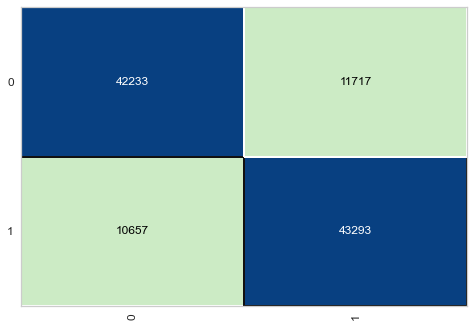

In [65]:
matriz_confusao_rn = ConfusionMatrix(rede_neural, cmap='GnBu')
matriz_confusao_rn.fit(X_over_train, Y_over_train)
matriz_confusao_rn.score(X_over_validacao, Y_over_validacao)

In [66]:
print(classification_report(Y_over_validacao, previsoes_rn))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     53950
           1       0.79      0.80      0.79     53950

    accuracy                           0.79    107900
   macro avg       0.79      0.79      0.79    107900
weighted avg       0.79      0.79      0.79    107900



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


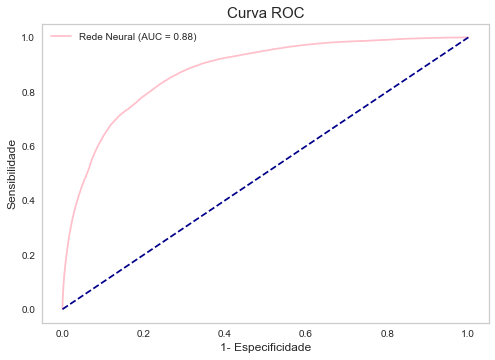

In [67]:
roc_redeneural = plota_roc_curve(rede_neural, X_over_validacao, Y_over_validacao, "Rede Neural")

#  <a name="secao_6"> Comparação Entre os Modelos </a>
[Voltar ao índice](#indice)   

Os modelos foram avaliados segundo a métrica **recall**. De forma que, resumidamente, obtivemos os seguintes resultados:

   -  **Random Forest**: 0.72
   - **Regressão Logistica**: 0.81
   - **GBDT**: 0.82
   - **Rede Neural**: 0.80    
   
Com isso, olhando apenas para o recall, a GBDT demonstrou possuir uma melhor performance, apesar de ter apresentado overfiting com o modelo retornado pelo GridSearchCV(). 
A GBDT também apresenta uma melhor curva ROC, estando mais localizada ao canto superior esquerdo do gráfico, sua AUC foi igual a 0.88.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.3s finished
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sk

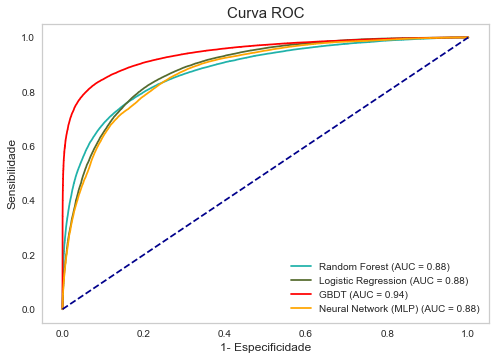

In [78]:
fig = plot_roc_curve(random_forest, X_over_validacao, Y_over_validacao, name='Random Forest', color='lightseagreen')
fig = plot_roc_curve(logistic_regression, X_over_validacao, Y_over_validacao, name='Logistic Regression', color='darkolivegreen', ax = fig.ax_)
fig = plot_roc_curve(GBDT, X_over_validacao, Y_over_validacao, name='GBDT', color='red', ax = fig.ax_)
fig = plot_roc_curve(rede_neural, X_over_validacao, Y_over_validacao, name='Neural Network (MLP)', color='orange', ax = fig.ax_)
plt.title('Curva ROC', fontsize=15)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1- Especificidade', fontsize=12)
plt.ylabel('Sensibilidade', fontsize=12)
plt.grid(color='w', linestyle='dotted', linewidth=1)
plt.legend()

#  <a name="secao_7"> Conclusão do desafio </a>
[Voltar ao índice](#indice)

Como o problema proposto no desafio era bastante aberto, foi escolhido uma abordagem exploratória de modelos de Machine Learning para realizar a previsão de uma possível tranasação envolvendo clientes do banco Santander. O problema envolveu um banco de dados do Kaggle e consistiu de um problema de classificação binária, também preferido pelo enunciado do desafio. 

O pré processamento foi curto uma vez que o dados eram bastante limpos e comportados, bastando apenas de um processo de balanceamento, no qual se usou uma técnica de oversampling. A análise preditiva de classificação buscou testar desde os modelos mais simples, como a Regressão Logística, até os mais sofisticados, como o GBDT. O que se observou foi que apesar do nivel de complexidade entre estas duas técnicas ser bastante diferente, ambas retornaram um valor de recall bastante próximos, de forma que o custo-benefício tende a Regressão Logística. 

O pior valor encontrado foi referente ao Random Forest.

A verificação de overfitting foi realizada apenas para o GBDT, mas poderia ter sido feito para todos os demais modelos. 